# ASL Classifier using PyTorch

### Imports and Setup

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import time
import copy
import matplotlib.pyplot as plt
import os

#set parameters
batch_size = 32
num_epochs = 10
input_size = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


### Data Preprocessing

In [21]:
# Data Transforms & Datasets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dir = "Train_Alphabet"
val_dir = "Test_Alphabet"

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

# For notebooks on Windows, set num_workers=0 to avoid multiprocessing issues.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

dataloaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}
class_names = train_dataset.classes
num_classes = len(class_names)
print("Found classes:", class_names)

Found classes: ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### Model Definitions and Helper Functions

In [24]:
# Model Definitions

def create_efficientnet_model(num_classes):
    model = models.efficientnet_b0(weights=True)
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

def create_convnext_model(num_classes):
    model = models.convnext_tiny(weights=True)
    for param in model.parameters():
        param.requires_grad = False
    # replace the first Linear layer in the classifier
    new_classifier = []
    for layer in model.classifier:
        if isinstance(layer, nn.Linear):
            in_features = layer.in_features
            new_classifier.append(nn.Linear(in_features, num_classes))
        else:
            new_classifier.append(layer)
    model.classifier = nn.Sequential(*new_classifier)
    return model

# Residual block inspired by ResNet with modifications
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.2):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_prob)
        
        # modified downsample: use average pooling then 1x1 conv to match dimensions.
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride, ceil_mode=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

# Custom CNN inspired by ResNet, with modified residual blocks.
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # convolution and pooling
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # residual layers with modified blocks
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        
        # global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride, dropout_prob=0.2))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1, dropout_prob=0.2))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # convolution, batch norm, ReLU, and pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # global average pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# function for creating the custom CNN
def create_custom_model(num_classes):
    return CustomCNN(num_classes)

# Training & Plotting Functions
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    
    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history


def plot_history(all_histories, num_epochs):
    os.makedirs("plots", exist_ok=True)
    for model_name, history in all_histories.items():
        epochs_range = range(1, num_epochs + 1)
        plt.figure()
        plt.plot(epochs_range, history["train_loss"], label='Train Loss')
        plt.plot(epochs_range, history["val_loss"], label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        loss_plot_path = os.path.join("plots", f"{model_name}_loss.png")
        plt.savefig(loss_plot_path)
        plt.show()
        print(f"Saved loss plot for {model_name} to {loss_plot_path}")
        
        plt.figure()
        plt.plot(epochs_range, history["train_acc"], label='Train Accuracy')
        plt.plot(epochs_range, history["val_acc"], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        acc_plot_path = os.path.join("plots", f"{model_name}_accuracy.png")
        plt.savefig(acc_plot_path)
        plt.show()
        print(f"Saved accuracy plot for {model_name} to {acc_plot_path}")


### Training and Evaluation

In [25]:
# train each model for later comparison
models_dict = {
    "EfficientNet": create_efficientnet_model(num_classes),
    "ConvNeXt": create_convnext_model(num_classes),
    "CustomCNN": create_custom_model(num_classes),
}

criterion = nn.CrossEntropyLoss()
all_histories = {}

for model_name, model_instance in models_dict.items():
    print(f"\nTraining {model_name} Model...")
    model_instance = model_instance.to(device)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_instance.parameters()), lr=1e-3)
    trained_model, history = train_model(model_instance, dataloaders, criterion, optimizer, device, num_epochs=num_epochs)
    save_path = f"{model_name}_asl_model.pth"
    torch.save(trained_model.state_dict(), save_path)
    print(f"{model_name} model saved to {save_path}")
    all_histories[model_name] = history


Training EfficientNet Model...

Epoch 1/10
----------
Train Loss: 1.8284 Acc: 0.5474
Val Loss: 1.0134 Acc: 0.7596

Epoch 2/10
----------
Train Loss: 1.2670 Acc: 0.6628
Val Loss: 0.7700 Acc: 0.8085

Epoch 3/10
----------
Train Loss: 1.1495 Acc: 0.6805
Val Loss: 0.6754 Acc: 0.8267

Epoch 4/10
----------
Train Loss: 1.0943 Acc: 0.6915
Val Loss: 0.6078 Acc: 0.8393

Epoch 5/10
----------
Train Loss: 1.0667 Acc: 0.6982
Val Loss: 0.5642 Acc: 0.8504

Epoch 6/10
----------
Train Loss: 1.0352 Acc: 0.7083
Val Loss: 0.5304 Acc: 0.8537

Epoch 7/10
----------
Train Loss: 1.0292 Acc: 0.7114
Val Loss: 0.5371 Acc: 0.8567

Epoch 8/10
----------
Train Loss: 1.0231 Acc: 0.7136
Val Loss: 0.5037 Acc: 0.8530

Epoch 9/10
----------
Train Loss: 1.0133 Acc: 0.7123
Val Loss: 0.5069 Acc: 0.8652

Epoch 10/10
----------
Train Loss: 1.0137 Acc: 0.7136
Val Loss: 0.5174 Acc: 0.8474

Training complete in 32m 16s
Best Val Acc: 0.8652
EfficientNet model saved to EfficientNet_asl_model.pth

Training ConvNeXt Model...

Ep

### Results

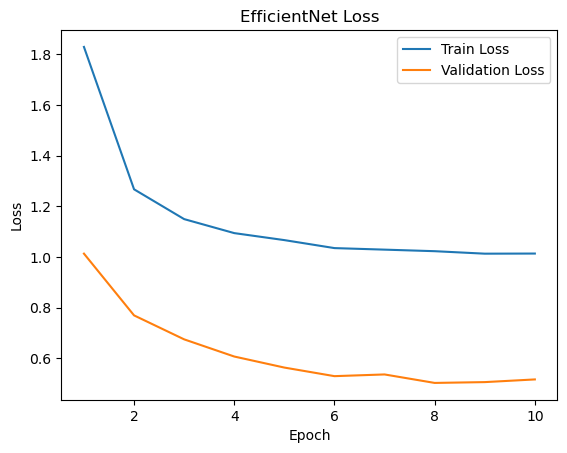

Saved loss plot for EfficientNet to plots\EfficientNet_loss.png


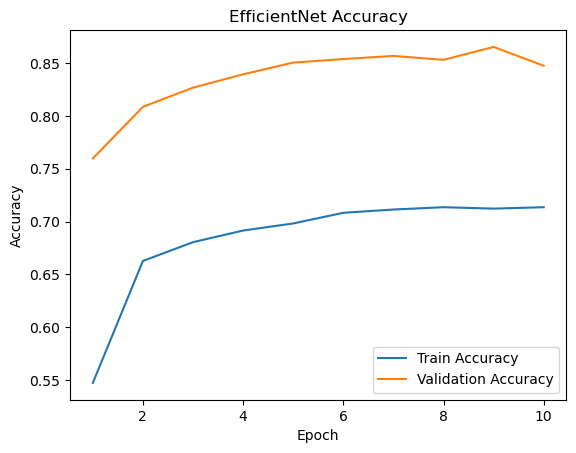

Saved accuracy plot for EfficientNet to plots\EfficientNet_accuracy.png


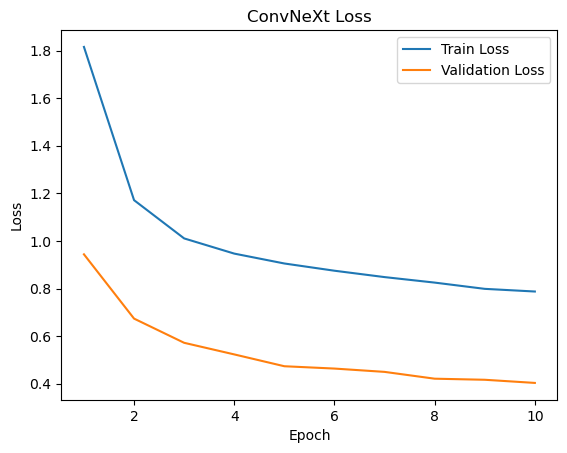

Saved loss plot for ConvNeXt to plots\ConvNeXt_loss.png


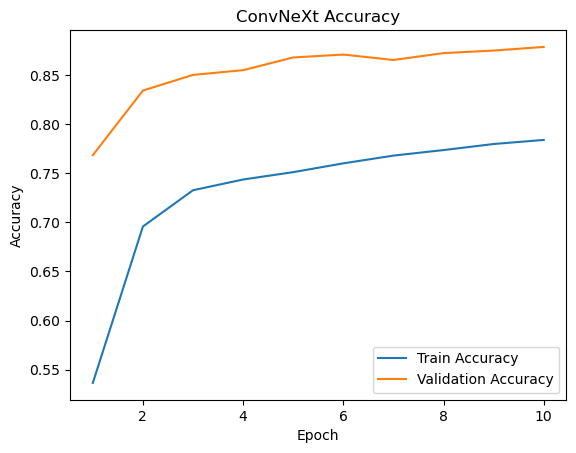

Saved accuracy plot for ConvNeXt to plots\ConvNeXt_accuracy.png


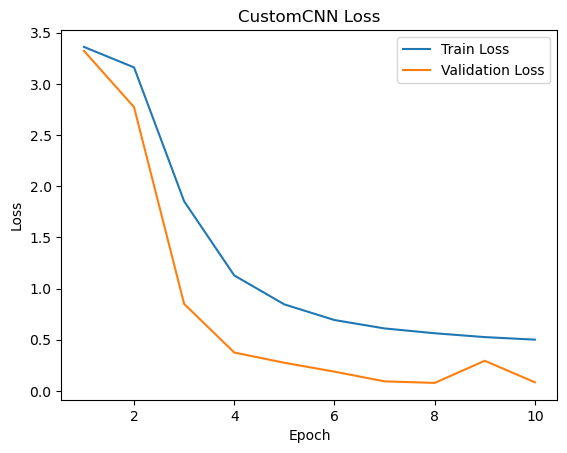

Saved loss plot for CustomCNN to plots\CustomCNN_loss.png


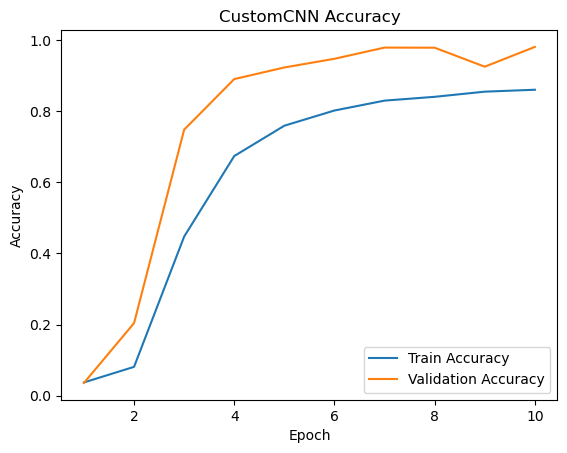

Saved accuracy plot for CustomCNN to plots\CustomCNN_accuracy.png


In [30]:
# Plotting Training History
plot_history(all_histories, num_epochs)
